In [1]:
import pandas as pd
import numpy as np

# Load data
loans = pd.read_csv('loans_full_schema.csv')

In [2]:
R_MAX = 0.3589          # Maximum APR
MONTHLY_DEFAULT_PROB = 1 - (1 - 0.06) ** (1 / 12)  # Approx. 0.005
MONTHLY_SURVIVAL = 1 - MONTHLY_DEFAULT_PROB     # ≈ 0.9958

def calculate_present_value(row):
    """Calculate the default-adjusted present value of monthly payments."""
    term = int(row['term'])  # Loan term in months (36 or 60)
    installment = row['installment']
    monthly_discount = 1 + R_MAX / 12
    
    total_pv = 0.0
    for t in range(1, term + 1):
        survival_prob = MONTHLY_SURVIVAL ** t
        discounted_payment = installment * survival_prob / (monthly_discount ** t)
        total_pv += discounted_payment
    return total_pv

# Calculate present value for each loan
loans['present_value'] = loans.apply(calculate_present_value, axis=1)

In [3]:
# Origination fee bounds by grade and term
fee_bounds = {
    '36': {
        'A': (0.0300, 0.0325),
        'B': (0.0300, 0.0400),
        'C': (0.0300, 0.0400),
        'D': (0.0300, 0.0400),
        'E': (0.0400, 0.0500),
        'F': (0.0400, 0.0500),
        'G': (0.0500, 0.0600),
    },
    '60': {
        'A': (0.0325, 0.0350),
        'B': (0.0350, 0.0400),
        'C': (0.0350, 0.0400),
        'D': (0.0350, 0.0400),
        'E': (0.0450, 0.0500),
        'F': (0.0450, 0.0500),
        'G': (0.0550, 0.0600),
    }
}

def assign_fee_bounds(row):
    term_str = str(row['term'])  # e.g., '36' or '60'
    grade = row['grade']
    return fee_bounds[term_str][grade]

# Create two new columns: min_fee and max_fee
loans[['min_fee', 'max_fee']] = loans.apply(
    lambda row: pd.Series(assign_fee_bounds(row)), axis=1
)

In [5]:
import pulp

# Initialize the problem
prob = pulp.LpProblem("Optimize_Origination_Fees", pulp.LpMaximize)

# Create a decision variable for each loan: f_i (origination fee)
fee_vars = {
    i: pulp.LpVariable(f"f_{i}", lowBound=loans.loc[i, 'min_fee'], upBound=loans.loc[i, 'max_fee'])
    for i in loans.index
}

prob += pulp.lpSum([
    loans.loc[i, 'loan_amount'] * fee_vars[i] for i in loans.index
]), "Total_Origination_Fee_Revenue"


for i in loans.index:
    L_i = loans.loc[i, 'loan_amount']
    PV_i = loans.loc[i, 'present_value']
    prob += (L_i - L_i * fee_vars[i] <= PV_i), f"APR_Constraint_{i}"


prob.solve()
loans['optimal_fee'] = [pulp.value(fee_vars[i]) for i in loans.index]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/athenaru/MATH 586/Lending-Club-Optimization/.venv/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/7j/kr4_442d7n50dfb1bfjvh1l00000gn/T/2db65801e316414d9a6259317a97f965-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/7j/kr4_442d7n50dfb1bfjvh1l00000gn/T/2db65801e316414d9a6259317a97f965-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 10005 COLUMNS
At line 30006 RHS
At line 40007 BOUNDS
At line 60008 ENDATA
Problem MODEL has 10000 rows, 10000 columns and 10000 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve determined that the problem was infeasible with tolerance of 1e-08
Analysis indicates model infeasible or unbounded
1 infeasibilities
Analysis indicates model infeasible or unbounded
Perturbing problem by 0.001% of 40000 - largest nonzero

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

Total Origination Fee Revenue: $6,349,188.12
grade
A    1239124.375
B    1974208.000
C    1787131.000
D     960967.000
E     305872.500
F      63576.250
G      18309.000
Name: origination_revenue, dtype: float64


/var/folders/7j/kr4_442d7n50dfb1bfjvh1l00000gn/T/ipykernel_14458/4142762345.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  revenue_by_grade = loans.groupby('grade')['origination_revenue'].sum().reindex(["A", "B", "C", "D", "E", "F", "G"])
/var/folders/7j/kr4_442d7n50dfb1bfjvh1l00000gn/T/ipykernel_14458/4142762345.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=revenue_by_grade.index, y=revenue_by_grade.values, palette="viridis")


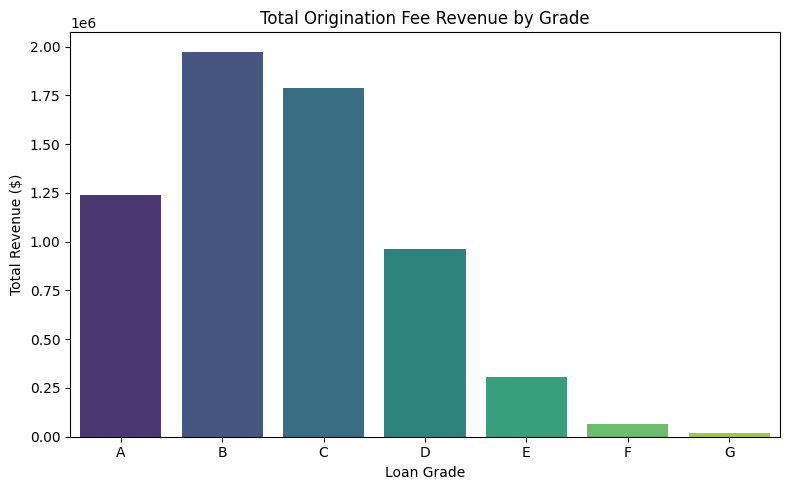

In [12]:
loans['origination_revenue'] = loans['loan_amount'] * loans['optimal_fee']
total_revenue = loans['origination_revenue'].sum()
print(f"Total Origination Fee Revenue: ${total_revenue:,.2f}")

revenue_by_grade = loans.groupby('grade')['origination_revenue'].sum().reindex(["A", "B", "C", "D", "E", "F", "G"])
print(revenue_by_grade)

plt.figure(figsize=(8, 5))
sns.barplot(x=revenue_by_grade.index, y=revenue_by_grade.values, palette="viridis")

plt.title("Total Origination Fee Revenue by Grade")
plt.xlabel("Loan Grade")
plt.ylabel("Total Revenue ($)")
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

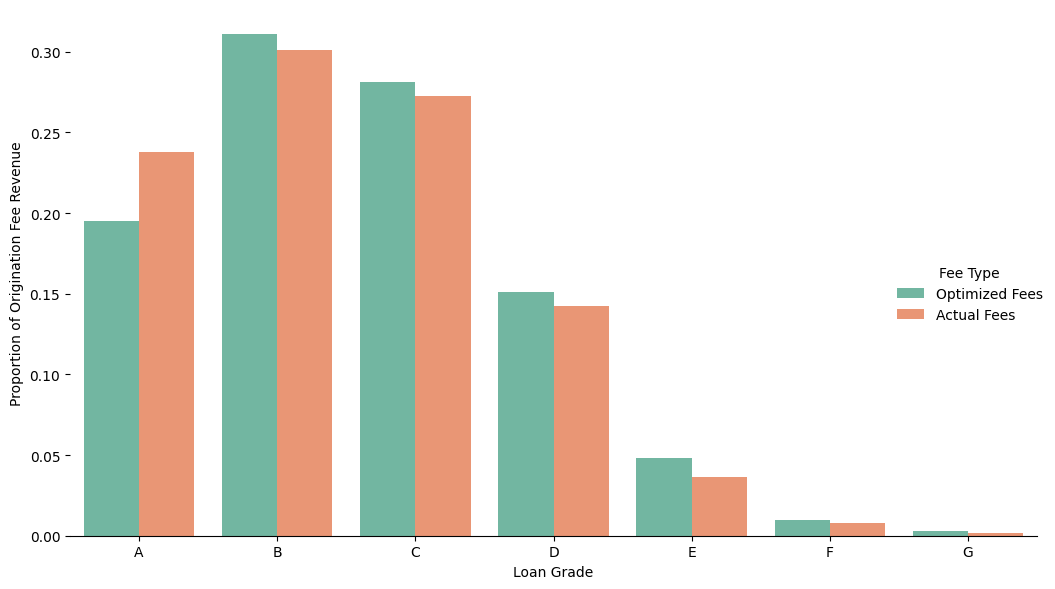

In [35]:
loan_grades = {
    'A': 414.6,
    'B': 524.5,
    'C': 474.8,
    'D': 248.0,
    'E': 63.3,
    'F': 14.0,
    'G': 2.6,
}
total_loan_originations = 1741.8
truth_proportions = {grade: orig / total_loan_originations for grade, orig in loan_grades.items()}

total_revenue = revenue_by_grade.sum()
my_proportions = revenue_by_grade / total_revenue

comparison_df = pd.DataFrame({
    'Optimized Fees': my_proportions,
    'Actual Fees': truth_proportions
}).reset_index()

# Combine the two proportions into one DataFrame
comparison_df = pd.DataFrame({
    'Grade': my_proportions.index,
    'Optimized Fees': my_proportions.values,
    'Actual Fees': list(truth_proportions.values())
})

# Melt the DataFrame to "long" format for grouped plotting
comparison_long_df = comparison_df.melt(id_vars="Grade", value_vars=["Optimized Fees", "Actual Fees"],
                                        var_name="Fee Type", value_name="Proportion")

# Set the figure size
plt.figure(figsize=(10, 6))

# Create a grouped barplot
g = sns.catplot(
    data=comparison_long_df, kind="bar",
    x="Grade", y="Proportion", hue="Fee Type", 
    palette="Set2", height=6, aspect=1.5
)

# Despine the plot for cleaner appearance
g.despine(left=True)

# Add labels and title
g.set_axis_labels("Loan Grade", "Proportion of Origination Fee Revenue")
g.set_titles("Comparison of Loan Proportions: My Proportions vs. Truth Proportions")

# Show the plot
plt.tight_layout()
plt.show(g)

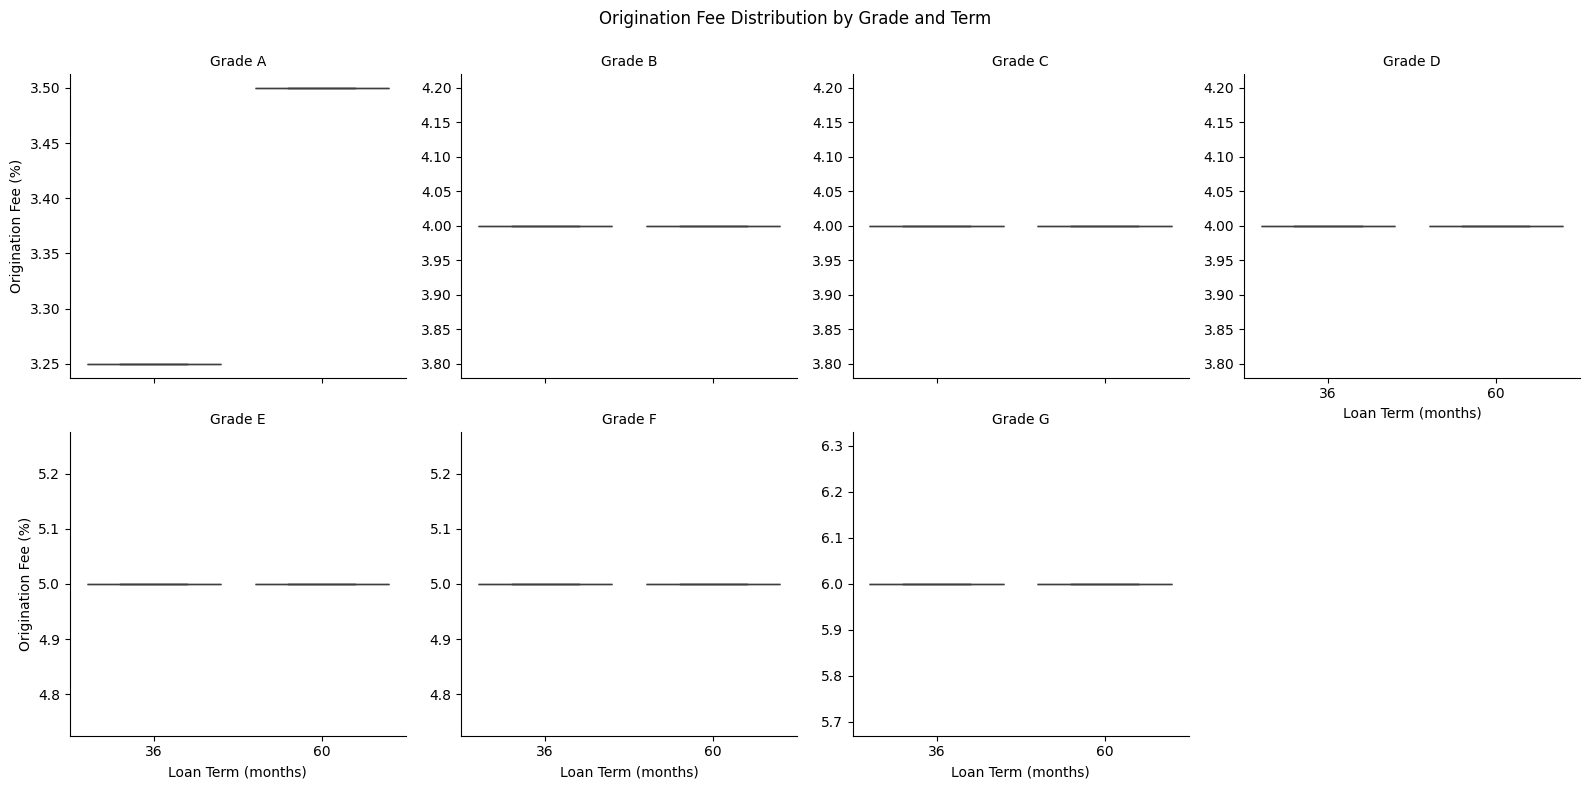

In [ ]:
loans['origination_fee_percent'] = loans['optimal_fee'] * 100

grade_order = ["A", "B", "C", "D", "E", "F", "G"]
loans['grade'] = pd.Categorical(loans['grade'], categories=grade_order, ordered=True)

g = sns.FacetGrid(loans, col="grade", col_order=grade_order, col_wrap=4, height=4, sharey=False)
g.map(sns.boxplot, "term", "origination_fee_percent", order=["36", "60"])

g.set_titles("Grade {col_name}")
g.set_axis_labels("Loan Term (months)", "Origination Fee (%)")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Origination Fee Distribution by Grade and Term")

plt.show()